<a href="https://colab.research.google.com/github/jodysuseno/TugasAkhirTKC_073-079/blob/main/CBIR_pneumonia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Collec data

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import glob
import cv2
import shutil

from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Activation
import os
import seaborn as sns

from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
import tensorflow as tf

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Model"

In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:27<00:00, 68.5MB/s]
100% 2.29G/2.29G [00:27<00:00, 89.6MB/s]


In [ ]:
!unzip \*.zip  && rm *.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

### Preprocessing

In [ ]:
SIZE = 256

TRAIN_DIR = "/content/chest_xray/train/"
VALID_DIR ="/content/chest_xray/val/"
TEST_DIR ="/content/chest_xray/test/"

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

train_generator = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 90,
    zoom_range = 0.2, 
    width_shift_range=0.1,
    height_shift_range=0.1, 
    shear_range=0.2,
    horizontal_flip=True, 
    fill_mode="nearest"
)

test_generator = ImageDataGenerator(
    rescale = 1./255,
    validation_split = 0.7
)

In [ ]:
train_images = train_generator.flow_from_directory(
    TRAIN_DIR,
    target_size=(SIZE, SIZE),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16,
    shuffle=True
)
val_images = test_generator.flow_from_directory(
    VALID_DIR,
    target_size=(SIZE, SIZE),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16,
    shuffle=True,
    subset = 'training'
)

test_images = test_generator.flow_from_directory(
    TEST_DIR,
    target_size=(SIZE, SIZE),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16,
    shuffle=False,
    subset = 'validation'
)

Found 5216 images belonging to 2 classes.
Found 6 images belonging to 2 classes.
Found 436 images belonging to 2 classes.


### Plot, Confution Matrix, Classification Report, and save model Function

In [ ]:
import matplotlib.pyplot as plt
def eval_plot(history, plotName):

  plt.figure(figsize=(14, 5))

  # Accuracy plot
  plt.subplot(1, 2, 1)
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  epochs = range(len(acc))
  acc_plot, = plt.plot(epochs, acc, 'r')
  val_acc_plot, = plt.plot(epochs, val_acc, 'b')
  plt.title('Training and Validation Accuracy')
  plt.legend([acc_plot, val_acc_plot], ['Training Accuracy', 'Validation Accuracy'])

  # Loss plot
  plt.subplot(1, 2, 2)
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(loss))
  loss_plot, = plt.plot(epochs, loss, 'r')
  val_loss_plot, = plt.plot(epochs, val_loss, 'b')
  plt.title('Training and Validation Loss')
  plt.legend([loss_plot, val_loss_plot], ['Training Loss', 'Validation Loss'])
  plt.savefig("/content/drive/MyDrive/model/"+plotName+".svg")

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def evaluate(Model, modelName):

  BS = 32;

  valid_generator = train_generator.flow_from_directory(
          TRAIN_DIR, 
          target_size=(SIZE,SIZE), 
          batch_size= BS, 
          class_mode='categorical',
          shuffle = False)

  batch_size = BS
  num_of_test_samples = len(valid_generator.filenames)

  Y_pred = Model.predict_generator(valid_generator, num_of_test_samples // batch_size+1)
  y_pred = np.argmax(Y_pred, axis=1)

  print('\nConfusion Matrix '+ modelName +'\n')
  cm = confusion_matrix(valid_generator.classes, y_pred)
  plt.figure(figsize=(8, 8))
  sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
  plt.xticks(ticks=[0.5, 1.5], labels=['Normal', 'Pneumonia'])
  plt.yticks(ticks=[0.5, 1.5], labels=['Normal', 'Pneumonia'])
  plt.xlabel("Predicted")
  plt.ylabel("Actual")
  plt.title("Confusion Matrix "+ modelName)
  plt.show()
  # plt.savefig("/content/drive/MyDrive/model/ConfMat"+modelName+".svg")

  print('\n\nClassification Report\n')
  target_names = ['Normal', 'Pneumonia']
  print(classification_report(valid_generator.classes, y_pred, target_names=target_names))

In [ ]:
# serialize Model2 model to JSON
def save_model(Model, modelName):
  model_json = Model.to_json()
  with open("/content/drive/MyDrive/model/"+ modelName +".json", "w") as json_file: json_file.write(model_json)
  # serialize weights to HDF5
  Model.save_weights("/content/drive/MyDrive/model/"+ modelName +"-json.h5")
  Model.save("/content/drive/MyDrive/model/"+ modelName +"-ori.h5")
  print("Saved model to disk")

### VGG16 Model

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input
from tensorflow.keras.applications.vgg19 import VGG19

In [ ]:
baseModelvgg19 = VGG19(include_top=False, input_tensor=Input(shape=(SIZE, SIZE, 3)))
baseModelvgg19.summary()

80150528/80134624 [==============================] - 3s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                              

In [ ]:
class FCHeadNet:
  def build(baseModel, classes, D):
    headModel = baseModel.output
    headModel = Flatten(name="flatten")(headModel)
    headModel = Dense(D, activation='relu')(headModel)
    headModel = Dropout(0.5)(headModel)
    headModel = Dense(D, activation='relu')(headModel)
    headModel = Dense(classes, activation='softmax')(headModel)
    return headModel

In [ ]:
headModel = FCHeadNet.build(baseModelvgg19, 2, 1024)
modelvgg19 = Model(inputs= baseModelvgg19.input, outputs=headModel)

In [ ]:
for layer in baseModelvgg19.layers:
  layer.trainable = False

modelvgg19.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [ ]:
modelvgg19.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

historyVgg19 = modelvgg19.fit(
    train_images,
    validation_data = val_images,
    batch_size=16,
    epochs = 100,
    callbacks = [
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_accuracy', 
            mode='max', 
            patience=5,  
            restore_best_weights=True
        )
    ]
)

Epoch 1/100
163/163 [==============================] - 177s 932ms/step - loss: 0.8602 - accuracy: 0.8248 - val_loss: 0.3570 - val_accuracy: 0.8333 - lr: 0.0010
Epoch 2/100
163/163 [==============================] - 148s 904ms/step - loss: 0.2979 - accuracy: 0.8706 - val_loss: 0.3262 - val_accuracy: 0.8333 - lr: 0.0010
Epoch 3/100
163/163 [==============================] - 147s 903ms/step - loss: 0.3014 - accuracy: 0.8664 - val_loss: 0.3212 - val_accuracy: 0.8333 - lr: 0.0010
Epoch 4/100
163/163 [==============================] - 147s 898ms/step - loss: 0.3095 - accuracy: 0.8447 - val_loss: 0.3543 - val_accuracy: 0.8333 - lr: 0.0010
Epoch 5/100
163/163 [==============================] - 146s 896ms/step - loss: 0.3368 - accuracy: 0.8158 - val_loss: 0.4896 - val_accuracy: 0.8333 - lr: 0.0010
Epoch 6/100
163/163 [==============================] - 146s 894ms/step - loss: 0.3397 - accuracy: 0.8299 - val_loss: 0.5918 - val_accuracy: 0.6667 - lr: 0.0010
Epoch 7/100
163/163 [===================

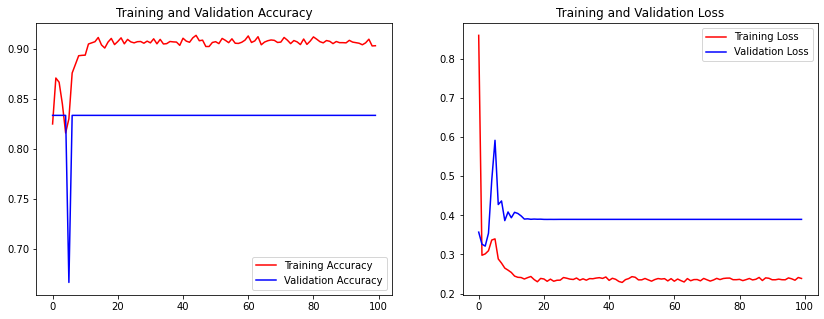

In [ ]:
eval_plot(historyVgg19, "AccLostVgg19Model")

Found 5216 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.



Confusion Matrix Vgg19Model



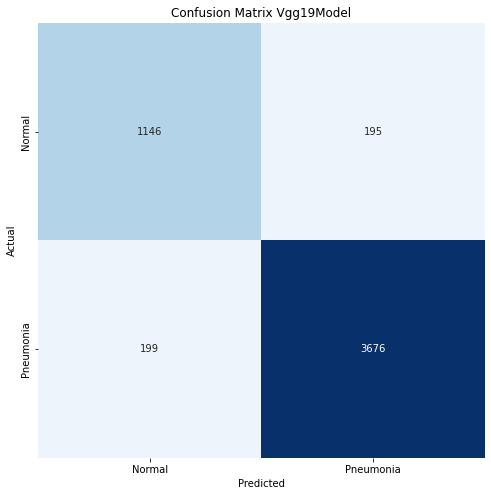



Classification Report

              precision    recall  f1-score   support

      Normal       0.85      0.85      0.85      1341
   Pneumonia       0.95      0.95      0.95      3875

    accuracy                           0.92      5216
   macro avg       0.90      0.90      0.90      5216
weighted avg       0.92      0.92      0.92      5216



In [ ]:
evaluate(modelvgg19, "Vgg19Model")

In [ ]:
save_model(modelvgg19, "Vgg19Model92Pnma")

Saved model to disk


### DenseNet Model

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input
from tensorflow.keras.applications.densenet import DenseNet201

In [ ]:
baseModelDenseNet201 = DenseNet201(include_top=False, input_tensor=Input(shape=(SIZE, SIZE, 3)))
baseModelDenseNet201.summary()

74850304/74836368 [==============================] - 1s 0us/step
Model: "densenet201"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 262, 262, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 128, 128, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                       

In [ ]:
class FCHeadNet:
  def build(baseModel, classes, D):
    headModel = baseModel.output
    headModel = Flatten(name="flatten")(headModel)
    headModel = Dense(D, activation='relu')(headModel)
    headModel = Dropout(0.5)(headModel)
    headModel = Dense(D, activation='relu')(headModel)
    headModel = Dense(classes, activation='softmax')(headModel)
    return headModel

In [ ]:
headModel = FCHeadNet.build(baseModelDenseNet201, 2, 1024)
modelDenseNet201 = Model(inputs= baseModelDenseNet201.input, outputs=headModel)

In [ ]:
for layer in baseModelDenseNet201.layers:
  layer.trainable = False

modelDenseNet201.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 262, 262, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 128, 128, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

In [ ]:
modelDenseNet201.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

historyDenseNet201 = modelDenseNet201.fit(
    train_images,
    validation_data = val_images,
    batch_size=16,
    epochs = 100,
    callbacks = [
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_accuracy', 
            mode='max', 
            patience=5,  
            restore_best_weights=True
        )
    ]
)

Epoch 1/100
163/163 [==============================] - 188s 964ms/step - loss: 3.6734 - accuracy: 0.8623 - val_loss: 0.5741 - val_accuracy: 0.6667 - lr: 0.0010
Epoch 2/100
163/163 [==============================] - 152s 929ms/step - loss: 0.3149 - accuracy: 0.9107 - val_loss: 0.3739 - val_accuracy: 0.8333 - lr: 0.0010
Epoch 3/100
163/163 [==============================] - 153s 937ms/step - loss: 0.2400 - accuracy: 0.9155 - val_loss: 0.1405 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 4/100
163/163 [==============================] - 151s 924ms/step - loss: 0.2034 - accuracy: 0.9298 - val_loss: 0.1621 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 5/100
163/163 [==============================] - 151s 924ms/step - loss: 0.2235 - accuracy: 0.9218 - val_loss: 0.2576 - val_accuracy: 0.8333 - lr: 0.0010
Epoch 6/100
163/163 [==============================] - 153s 938ms/step - loss: 0.1961 - accuracy: 0.9229 - val_loss: 0.4755 - val_accuracy: 0.8333 - lr: 0.0010
Epoch 7/100
163/163 [===================

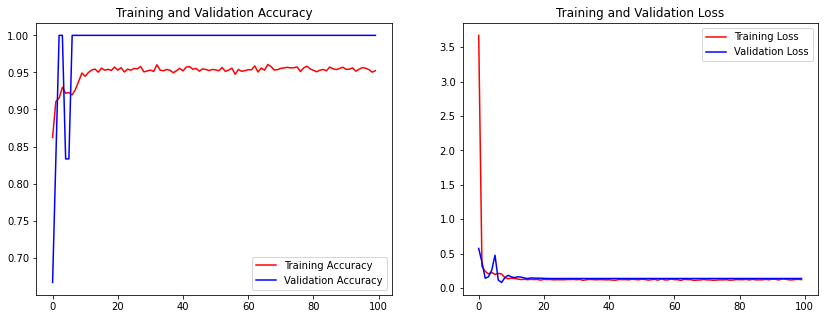

In [ ]:
eval_plot(historyDenseNet201, "AccLostDenseNet201Model")

Found 5216 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.



Confusion Matrix DenseNet201Model



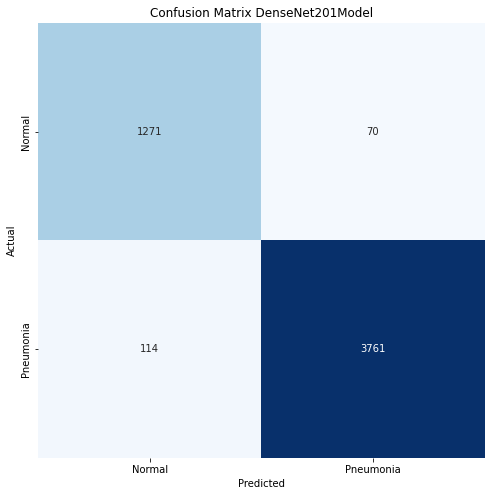



Classification Report

              precision    recall  f1-score   support

      Normal       0.92      0.95      0.93      1341
   Pneumonia       0.98      0.97      0.98      3875

    accuracy                           0.96      5216
   macro avg       0.95      0.96      0.95      5216
weighted avg       0.97      0.96      0.96      5216



In [ ]:
evaluate(modelDenseNet201, "DenseNet201Model")

In [ ]:
save_model(modelDenseNet201, "DenseNet201Model96Pnma")

Saved model to disk


### Load & Evaluate Model

In [ ]:
from keras.models import load_model
Vgg19Model92Pnma = load_model('/content/drive/MyDrive/model/Vgg19Model92Pnma-ori.h5')
Vgg19Model92Pnma.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [ ]:
DenseNet201Model96Pnma = load_model('/content/drive/MyDrive/model/DenseNet201Model96Pnma-ori.h5')
DenseNet201Model96Pnma.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 262, 262, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 128, 128, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

def eva_one(Model):
  BS = 16;

  valid_generator = train_generator.flow_from_directory(
          TRAIN_DIR, 
          target_size=(SIZE,SIZE), 
          batch_size= BS, 
          class_mode='categorical',
          shuffle = False)

  batch_size = BS
  num_of_test_samples = len(valid_generator.filenames)

  Y_pred = Model.predict_generator(valid_generator, num_of_test_samples // batch_size+1)
  y_pred = np.argmax(Y_pred, axis=1)

  target_names = ['Normal', 'Pneumonia']
  # print(classification_report(valid_generator.classes, y_pred, target_names=target_names))


  # accuracy: (tp + tn) / (p + n)
  accuracy = accuracy_score(valid_generator.classes, y_pred)
  print('Accuracy: %f' % accuracy)
  # precision tp / (tp + fp)
  precision = precision_score(valid_generator.classes, y_pred)
  print('Precision: %f' % precision)
  # recall: tp / (tp + fn)
  recall = recall_score(valid_generator.classes, y_pred)
  print('Recall: %f' % recall)
  # f1: 2 tp / (2 tp + fp + fn)
  f1 = f1_score(valid_generator.classes, y_pred)
  print('F1 score: %f' % f1)

In [ ]:
eva_one(Vgg19Model92Pnma)

Found 5216 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


Accuracy: 0.923696
Precision: 0.950039
Recall: 0.947097
F1 score: 0.948566


In [ ]:
eva_one(DenseNet201Model96Pnma)

Found 5216 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


Accuracy: 0.964149
Precision: 0.982975
Recall: 0.968516
F1 score: 0.975692


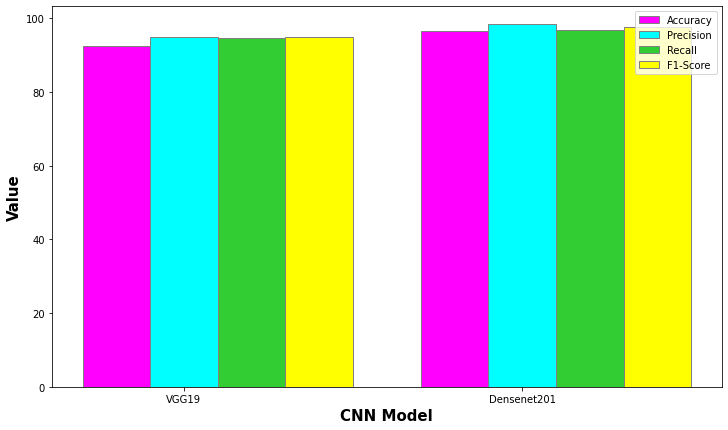

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
 
# set width of bar
barWidth = 0.20
fig = plt.subplots(figsize =(12, 7))
 
def in_prs(a):
  b = a * 100
  return b


ACC = [in_prs(0.923696), in_prs(0.964149)]
PRS = [in_prs(0.950039), in_prs(0.982975)]
REC = [in_prs(0.947097), in_prs(0.968516)]
FSC = [in_prs(0.948566), in_prs(0.975692)]
 
# Set position of bar on X axis
br1 = np.arange(len(ACC))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]
 
# Make the plot
plt.bar(br1, ACC, color ='magenta', width = barWidth,
        edgecolor ='grey', label ='Accuracy')
plt.bar(br2, PRS, color ='cyan', width = barWidth,
        edgecolor ='grey', label ='Precision')
plt.bar(br3, REC, color ='limegreen', width = barWidth,
        edgecolor ='grey', label ='Recall')
plt.bar(br4, FSC, color ='yellow', width = barWidth,
        edgecolor ='grey', label ='F1-Score')
 
# Adding Xticks
plt.xlabel('CNN Model', fontweight ='bold', fontsize = 15)
plt.ylabel('Value', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(ACC))],
        ['VGG19', 'Densenet201'])
 
plt.legend()
plt.show()

### Retrieval VGG19

In [24]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
# from tensorflow.keras.applications.densenet import DenseNet201, preprocess_input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input
import numpy as np

class FeatureExtractor:

    def __init__(self):

        self.model = load_model('/content/drive/MyDrive/model/Vgg19Model92Pnma-ori.h5')
    

    def extract(self, img):
        height = 256
        width = 256
        img = img.resize((height, width)).convert("RGB")
        x = image.img_to_array(img)  # to np.array
        x = np.expand_dims(x, axis=0)  # (H, W, C) -> (1, H, W, C)
        feature = self.model.predict(x)[0]  # (1, 4096) -> (4096)
        return feature/np.linalg.norm(feature)  # normalize

In [25]:
from pathlib import Path
import numpy as np
from PIL import Image

base_dir = '/content/Pneumonia'
feature_dir = '/content/feature_extract'

img_paths = list()
features = list()

fe = FeatureExtractor()
for img_path in sorted(Path(base_dir).glob('*.jpeg')):
  img_paths.append(img_path)
  feature = fe.extract(img=Image.open(img_path))
  features.append(feature)

features = np.array(features)
np.save(feature_dir + '/extracted_feature_vgg19.npy', features)

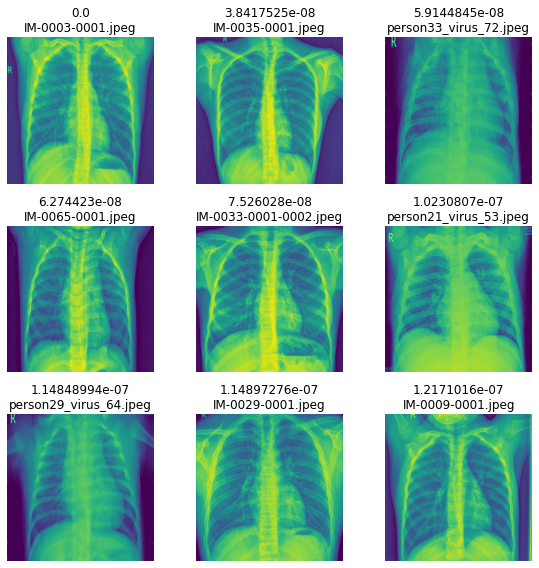

In [26]:
import matplotlib.pyplot as plt
import numpy as np

query_image = img_paths[1]
img = Image.open(query_image)

query = fe.extract(img)

dists = np.linalg.norm(features - query, axis=1)

ids = np.argsort(dists)[:9]
scores = [(dists[id], img_paths[id]) for id in ids]

axes = list()
fig = plt.figure(figsize=(8,8))

for a in range(3 * 3):
  axes.append(fig.add_subplot(3, 3, a+1))

  score = scores[a]

  nama_citra = os.path.basename(score[1])

  subplot_title = str(score[0]) + f"\n{nama_citra}"
  axes[-1].set_title(subplot_title)

  plt.axis('off')
  plt.imshow(Image.open(score[1]))

fig.tight_layout()
plt.show()

### Retrieval Densenet201

In [3]:
# Download dataset
!rm -rf /content/Plant
!rm -rf /content/corn
!rm -rf /content/dataset
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jodysuseno/MLdataset/main/Pneumonia-CBIR.zip \
    -O /content/Pneumonia-CBIR.zip

--2022-01-12 10:53:18--  https://raw.githubusercontent.com/jodysuseno/MLdataset/main/Pneumonia-CBIR.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21700611 (21M) [application/zip]
Saving to: ‘/content/Pneumonia-CBIR.zip’

/content/Pneumonia- 100%[===================>]  20.70M  --.-KB/s    in 0.1s    

2022-01-12 10:53:18 (162 MB/s) - ‘/content/Pneumonia-CBIR.zip’ saved [21700611/21700611]



In [4]:
import os
import zipfile

os.mkdir('/content/Pneumonia')
local_zip = '/content/Pneumonia-CBIR.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/Pneumonia')
zip_ref.close()

In [10]:
files = os.listdir('/content/Pneumonia')
# print(files)
for index, file in enumerate(files):
  path_id = "/content/Pneumonia/"+file
  image = Image.open(path_id)
  new_image = image.resize((256, 256))
  new_image.save(path_id)

In [ ]:
os.mkdir('/content/feature_extract')

In [21]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
# from tensorflow.keras.applications.densenet import DenseNet201, preprocess_input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input
import numpy as np

class FeatureExtractor:

    def __init__(self):

        self.model = load_model('/content/drive/MyDrive/model/DenseNet201Model96Pnma-ori.h5')
    

    def extract(self, img):
        height = 256
        width = 256
        img = img.resize((height, width)).convert("RGB")
        x = image.img_to_array(img)  # to np.array
        x = np.expand_dims(x, axis=0)  # (H, W, C) -> (1, H, W, C)
        feature = self.model.predict(x)[0]  # (1, 4096) -> (4096)
        return feature/np.linalg.norm(feature)  # normalize

In [22]:
from pathlib import Path
import numpy as np
from PIL import Image

base_dir = '/content/Pneumonia'
feature_dir = '/content/feature_extract'

img_paths = list()
features = list()

fe = FeatureExtractor()
for img_path in sorted(Path(base_dir).glob('*.jpeg')):
  img_paths.append(img_path)
  feature = fe.extract(img=Image.open(img_path))
  features.append(feature)

features = np.array(features)
np.save(feature_dir + '/extracted_feature.npy', features)

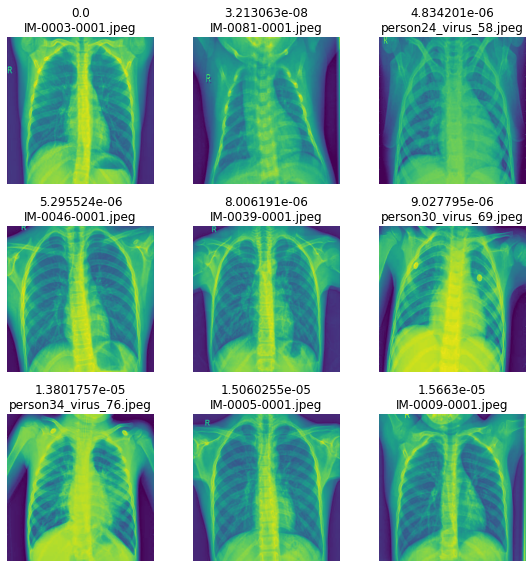

In [23]:
import matplotlib.pyplot as plt
import numpy as np

query_image = img_paths[1]
img = Image.open(query_image)

query = fe.extract(img)

dists = np.linalg.norm(features - query, axis=1)

ids = np.argsort(dists)[:9]
scores = [(dists[id], img_paths[id]) for id in ids]

axes = list()
fig = plt.figure(figsize=(8,8))

for a in range(3 * 3):
  axes.append(fig.add_subplot(3, 3, a+1))

  score = scores[a]

  nama_citra = os.path.basename(score[1])

  subplot_title = str(score[0]) + f"\n{nama_citra}"
  axes[-1].set_title(subplot_title)

  plt.axis('off')
  plt.imshow(Image.open(score[1]))

fig.tight_layout()
plt.show()